## Using Multinomial Model to classify the songs

In [11]:
import pandas as pd

df_train = pd.read_csv('../dataset/train_lyrics_1000.csv')
df_test = pd.read_csv('../dataset/valid_lyrics_200.csv')

df_train.tail()

,file,artist,title,lyrics,genre,mood,year
995,TRBIGRY128F42597B3.h5,Sade,All About Our Love,Its all about our love\nSo shall it be forever...,R&B,sad,2000
996,TRBIIEU128F9307C88.h5,New Found Glory,Don't Let Her Pull You Down,It's time that I rain on your parade\nWatch as...,Rock,happy,2009
997,TRBIIJY12903CE4755.h5,Mindy McCready,Ten Thousand Angels,Speakin of the devil\nLook who just walked in\...,Country,happy,1996
998,TRBIIOT128F423C594.h5,Joy Division,Leaders Of Men,Born from some mother's womb\nJust like any ot...,Rock,sad,1978
999,TRBIJYB128F14AE326.h5,Seventh Day Slumber,Shattered Life,"This wanting more from me is tearing me, it's ...",Rock,sad,2005


In [12]:
X_train = df_train['lyrics']
y_train = df_train['mood']

X_test = df_test['lyrics']
y_test = df_test['mood']

## Vectorizing the data

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels, val_texts):
   """Vectorizes texts as ngram vectors.

   1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

   # Arguments
       train_texts: list, training text strings.
       train_labels: np.ndarray, training labels.
       val_texts: list, validation text strings.

   # Returns
       x_train, x_val: vectorized training and validation texts
   """
   # Create keyword arguments to pass to the 'tf-idf' vectorizer.
   kwargs = {
           'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
           'dtype': 'int32',
           'strip_accents': 'unicode',
           'decode_error': 'replace',
           'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'stop_words': 'english',
            'lowercase': True,
           'min_df': MIN_DOCUMENT_FREQUENCY,
   }
   vectorizer = TfidfVectorizer(**kwargs)

   # Learn vocabulary from training texts and vectorize training texts.
   x_train = vectorizer.fit_transform(train_texts)

   # Vectorize validation texts.
   x_val = vectorizer.transform(val_texts)

   # Select top 'k' of the vectorized features.
   selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
   selector.fit(x_train, train_labels)
   x_train = selector.transform(x_train)
   x_val = selector.transform(x_val)

   x_train = x_train.astype('float32')
   x_val = x_val.astype('float32')
   return x_train, x_val

In [20]:
train_vect, test_vect = ngram_vectorize(X_train, y_train, X_test)

C:\Users\Nidhi\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


## Using the model to see the predicted result

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

clf = MultinomialNB(alpha=0.01,class_prior=None, fit_prior=False)
clf.fit(train_vect,y_train)
predicted_values = clf.predict(test_vect)
actual_values = y_test
df = pd.DataFrame()
df['actual'] = actual_values
df['predicted'] = predicted_values
df.head()


,actual,predicted
0,happy,happy
1,sad,sad
2,happy,happy
3,sad,sad
4,sad,sad


## Plotting the confusion matrix

In [22]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

def plot_cm(X, y, clf, title, dest):

    cm = metrics.confusion_matrix(y, clf.predict(X))

    np.set_printoptions(suppress=True)
    mpl.rc("figure", figsize=(4, 2))

    hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
    plt.title(title)
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.tight_layout()
    plt.savefig(dest, dpi=300)
    plt.show()

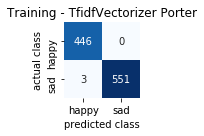

In [23]:
plot_cm(train_vect, y_train, clf, 'Training - TfidfVectorizer Porter', '../dataset/train.png')

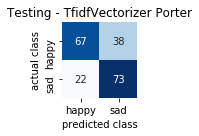

In [24]:
plot_cm(test_vect, y_test, clf, 'Testing - TfidfVectorizer Porter', '../dataset/test.png')

## Calculating the Accuracy, Precision, Recall and F-1 score

In [25]:
from sklearn import metrics
acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label= 'happy')
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label= 'happy')
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label= 'happy')
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [26]:
a = acc_scorer(estimator=clf, X=train_vect, y_true=y_train)
p = pre_scorer(estimator=clf, X=train_vect, y_true=y_train)
r = rec_scorer(estimator=clf, X=train_vect, y_true=y_train)
f = f1_scorer(estimator=clf, X=train_vect, y_true=y_train)
#roc = auc_scorer(estimator=clf, X=train_vect, y_true=y_train)

print('Accuracy for train is: ', a*100)
print('Precision for train  is: ', p*100)
print('Recall for train is: ', r*100)
print('F1 score for train is: ', f*100)


a1 = acc_scorer(estimator=clf, X=test_vect, y_true=y_test)
p1 = pre_scorer(estimator=clf, X=test_vect, y_true=y_test)
r1 = rec_scorer(estimator=clf, X=test_vect, y_true=y_test)
f1 = f1_scorer(estimator=clf, X=test_vect, y_true=y_test)
print('________________________________________________________________________\n')
print('Accuracy for test is: ', a1*100)
print('Precision for test is: ', p1*100)
print('Recall for test is: ', r1*100)
print('F1 score for test is: ', f1*100)

Accuracy for train is:  99.7
Precision for train  is:  99.33184855233853
Recall for train is:  100.0
F1 score for train is:  99.66480446927373
________________________________________________________________________

Accuracy for test is:  70.0
Precision for test is:  75.28089887640449
Recall for test is:  63.8095238095238
F1 score for test is:  69.0721649484536


## Pickling the model

In [31]:
import pickle

pickle_out = open('Finalmodel.pkl', 'wb')
pickle.dump(clf, pickle_out)
print(pickle_out)
pickle_out.close()

<_io.BufferedWriter name='Finalmodel.pkl'>


In [28]:
import pickle
import pandas as pd
pickle_in = open('Finalmodel.pkl', 'rb')
Mymodel = pickle.load(pickle_in)

## Function to make predictions from the pickled model

In [29]:
def model_predict(text):
    test_text = pd.Series(text)
    train_x,test_x=ngram_vectorize(X_train, y_train, test_text)
    return Mymodel.predict(test_x) 

## Test example

In [30]:
model_predict("I can't forget my love. I am sad everyday")

C:\Users\Nidhi\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


array(['sad'], dtype='<U5')